# QU fitting with beam

Here we perform QU fitting with nested sampling (Dynesty) for two RM components

In [328]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../Optimus-Primal')

import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.qu_fitting as qu_fitting
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy import signal
from dynesty import plotting as dyplot
import dynesty

Here we choose observaitonal parameters

In [515]:
c = 2.92 * 10**8
m_size = 128 # number of samples in the signal
down_sample = 1 #simulation of channel averaging (downsampling of the signal)
ISNR = -10. #input noise level
freq0 =  np.linspace(400, 800, m_size) * 10**6 #frequency coverage
#estimate lambda and frequency channel widths
dfreq = np.abs(freq0[1] - freq0[0]) 
lambda2 = (c/freq0)**2
lambda1 = np.sqrt(lambda2)
dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2

location = np.array([20., 0.]) * np.pi/180. ## location of source in beam

Below we generate a jones matrix based on a box beam

In [516]:
#assuming a box beam
l = np.sin(location[0]) * np.cos(location[1])
m = np.sin(location[1]) 
beam_size_x = 20. # meters
beam_size_y = 1. # meters
J11 = np.sinc(l * beam_size_x /lambda1/ 2.) * np.sinc(m * beam_size_y /lambda1/ 2.)
J22 = np.sinc(l * beam_size_x /lambda1/ 2.)* np.sinc(m * beam_size_y /lambda1/ 2.)
J12 = J11 * 0
J21 = J22 * 0.

Below we calculate a mueller matrix based on a the jones matrix

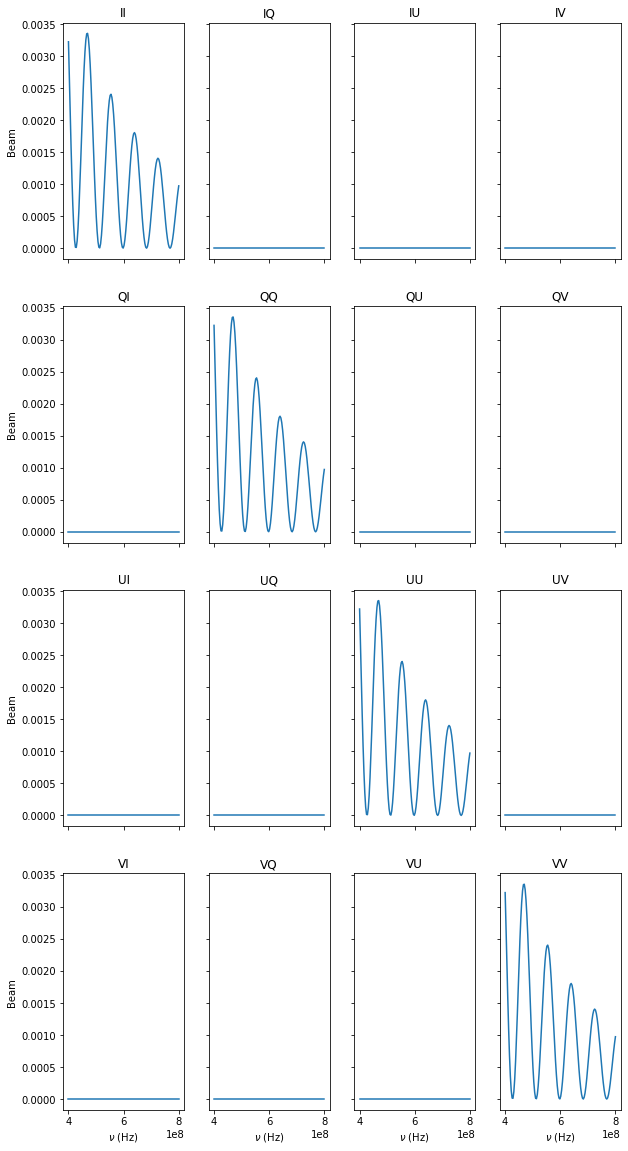

In [517]:
M_IQUV = np.zeros((4, 4, len(J11)))

M_IQUV[0, 0, :] = (J11 * np.conj(J11)
                      + J12 * np.conj(J12)
                      + J21 * np.conj(J21)
                      + J22 * np.conj(J22))/2.
M_IQUV[0, 1, :] = (J11 * np.conj(J11)
                      - J12 * np.conj(J12)
                      + J21 * np.conj(J21)
                      - J22 * np.conj(J22))/2.
M_IQUV[0, 2, :] = np.real(J11 * np.conj(J12) 
                             + J21 * np.conj(J22))
M_IQUV[0, 3, :] = np.imag(J11 * np.conj(J12) 
                             + J21 * np.conj(J22))

M_IQUV[1, 0, :] = (J11 * np.conj(J11)
                      + J12 * np.conj(J12)
                      - J21 * np.conj(J21)
                      - J22 * np.conj(J22))/2.
M_IQUV[1, 1, :] = (J11 * np.conj(J11)
                      - J12 * np.conj(J12)
                      - J21 * np.conj(J21)
                      + J22 * np.conj(J22))/2.
M_IQUV[1, 2, :] = np.real(J11 * np.conj(J12) 
                             - J21 * np.conj(J22))
M_IQUV[1, 3, :] = np.imag(J11 * np.conj(J12) 
                             - J21 * np.conj(J22))

M_IQUV[2, 0, :] = np.real(J11 * np.conj(J21) 
                             + J12 * np.conj(J22))
M_IQUV[2, 1, :] = np.real(J11 * np.conj(J21) 
                             - J12 * np.conj(J22))
M_IQUV[2, 2, :] = np.real(J11 * np.conj(J22) 
                             + J12 * np.conj(J21))
M_IQUV[2, 3, :] = np.imag(J11 * np.conj(J22) 
                             - J12 * np.conj(J21))

M_IQUV[3, 0, :] = -np.imag(J11 * np.conj(J21) 
                             + J12 * np.conj(J22))
M_IQUV[3, 1, :] = -np.imag(J11 * np.conj(J21) 
                             - J12 * np.conj(J22))
M_IQUV[3, 2, :] = -np.imag(J11 * np.conj(J22) 
                             + J12 * np.conj(J21))
M_IQUV[3, 3, :] = np.real(J11 * np.conj(J22) 
                             - J12 * np.conj(J21))
fig, ax = plt.subplots(4, 4, figsize=(10, 20), sharex=True, sharey=True)
pols = ["I", "Q", "U", "V"]
for i in range(4):
    for j in range(4):
        ax[i,j].plot(freq0, M_IQUV[i,j,:])
        ax[-1,j].set_xlabel("$\\nu$ (Hz)")
        ax[i,0].set_ylabel("Beam")
        ax[i,j].set_title(pols[i] + pols[j])

In [518]:
#model for a single component
def component(lambda2, P, rm, chi0):
    return P * np.cos(2 * rm * lambda2 + 2 * chi0) + 1j * P * np.sin(2 * rm * lambda2 + 2 * chi0)
#ideal model of two components
def model(lambda2, P1, rm1, chi1):
    return component(lambda2, P1, rm1, chi1) 
def model_with_beam(lambda2, P1, rm1, chi1):
    result = model(lambda2, P1, rm1,chi1)
    return M_IQUV[1, 1, :] * np.real(result) + 1j * M_IQUV[2, 2, :] * np.imag(result) 

Here we choose the true parameters (P, rm, chi0, ....)

In [519]:
true_params = (3, 50, -np.pi/2.)

Here we generate the measurements with noise assuming no averaging

In [520]:
y0 = model_with_beam(lambda2, *true_params)
y_true = model(lambda2, *true_params)
sigma = 10**(-ISNR/20.)  * np.linalg.norm(y0) * 1./ np.sqrt(m_size * 2)
print(sigma)
y = (y0 + np.random.normal(0, sigma, int(m_size)) + 1j * np.random.normal(0, sigma, int(m_size)))

0.00948769634215734


Text(0.5, 0, 'Frequency (Hz)')

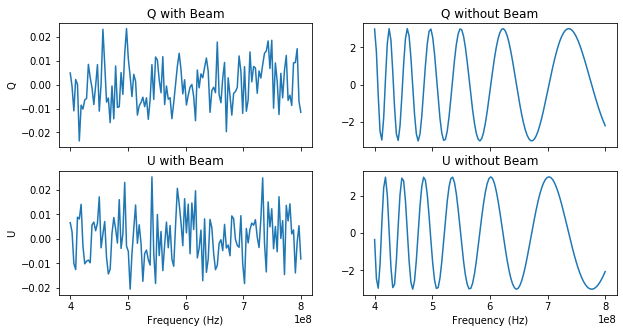

In [521]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=False)
ax[0, 0].plot(freq0, np.real(y))
ax[0, 0].set_title("Q with Beam")
ax[0, 1].plot(freq0, np.real(y_true))
ax[0, 1].set_title("Q without Beam")
ax[1, 0].plot(freq0, np.imag(y))
ax[1, 0].set_title("U with Beam")
ax[1, 1].plot(freq0, np.imag(y_true))
ax[1, 1].set_title("U without Beam")
ax[0, 0].set_ylabel("Q")
ax[1, 0].set_ylabel("U")
ax[1, 0].set_xlabel("Frequency (Hz)")
ax[1, 1].set_xlabel("Frequency (Hz)")

Here we transform the n dimensional cube [0, 1)^n to sample the range of parameter.

For example, if we want to sample RM between +/- 400, we transform following 400 * (2 * RM - 1). If we want to sample 10 > P >= 0, we transform 10 * P.


In [522]:
def prior_transform(utheta):
    P1, rm1, chi1 = utheta
    return 10 * P1, 200 * (2 * rm1 - 1), np.pi * chi1

Next we set the log likelihood up (which is a normal distribution here), and the nested sampling algo.

I have found bound with multi works faster than single.

In [523]:
model_choice = model
nlive = 1500
likelihood = lambda theta : qu_fitting.loglike(theta, model_choice, lambda2, y, sigma)
sampler = dynesty.NestedSampler(likelihood, prior_transform, bound='multi', ndim=len(true_params), nlive=nlive)

Below we run the sampler, but we also have to put convergence constraints on. So nested sampling works by sampling to estimate the evidice (the normalization of the posterior).

Below we sample until the dlogz (remaining evidence not accounted for) is below a given value.

In [524]:
sampler.run_nested(dlogz=0.05)

28022it [01:07, 415.61it/s, +1500 | bound: 37 | nc: 1 | ncall: 134827 | eff(%): 21.896 | loglstar:   -inf < -118.524 <    inf | logz: -134.183 +/-  0.136 | dlogz:  0.000 >  0.050] 


In [525]:
res = sampler.results  # grab our results

In [526]:
print('Keys:', res.keys(),'\n')  # print accessible keys
res.summary()  # print a summary
print(res['samples'].shape)
print("Mean:")
print(np.mean(res['samples'],axis=0))
print("RMS:")
print(np.std(res['samples'],axis=0))
print("True:")
print(true_params)

Keys: dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale']) 

Summary
nlive: 1500
niter: 28022
ncall: 134827
eff(%): 21.896
logz: -134.183 +/-  0.136
(29522, 3)
Mean:
[ 0.50324217 15.95626893  1.74002209]
RMS:
[ 1.50468342 93.10838194  0.7845142 ]
True:
(3, 50, -1.5707963267948966)


Below we print density plots:

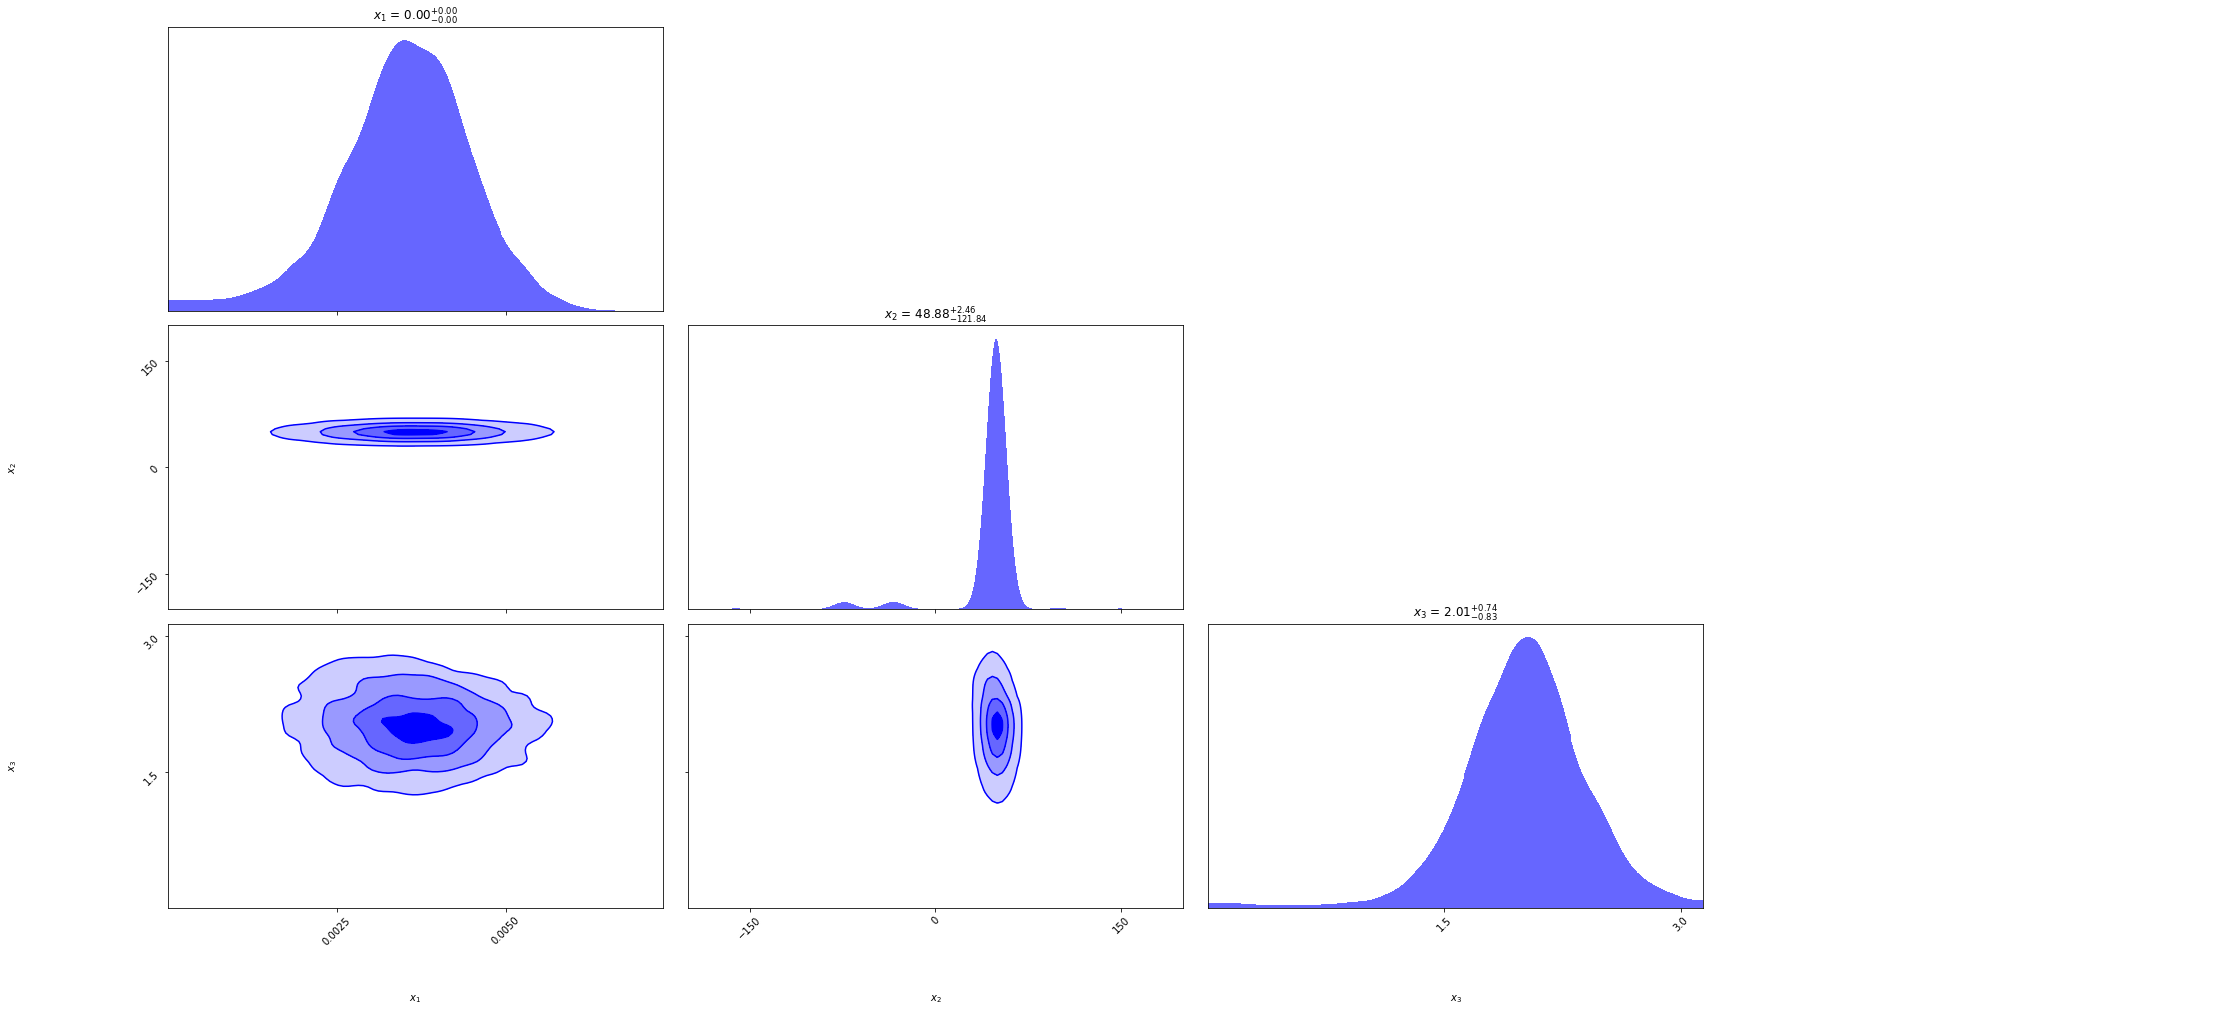

In [527]:
fig, axes = plt.subplots(len(true_params), len(true_params)+1, figsize=(35, 15))
axes = axes.reshape((len(true_params), len(true_params)+1))
[a.set_frame_on(False) for a in axes[:, len(true_params)]]
[a.set_xticks([]) for a in axes[:, len(true_params)]]
[a.set_yticks([]) for a in axes[:, len(true_params)]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(res, color='blue', truth_color='black',
                           show_titles=True, max_n_ticks=3,
                           quantiles=None, fig=(fig, axes[:, :len(true_params)]))
plt.show()